In [1]:
# Data analysis libraries
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
# import calendar

# Matplotlib libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# Show table names, columns, and data types
for table in Base.classes:
    print(f"Table name: {table.__table__.name}")
    for c in table.__table__.columns:
        print(f"   {c.name} {c.type}", end='')
        if c.primary_key:
            print("  PRIMARY KEY")
        else:
            print()

Table name: measurement
   id INTEGER  PRIMARY KEY
   station TEXT
   date TEXT
   prcp FLOAT
   tobs FLOAT
Table name: station
   id INTEGER  PRIMARY KEY
   station TEXT
   name TEXT
   latitude FLOAT
   longitude FLOAT
   elevation FLOAT


In [5]:
# Save references to each table
Meas = Base.classes.measurement
Sta = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [7]:
# Show all records from 'station'
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [8]:
# Show first 10 records from 'measurement'
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

# Exploratory Climate Analysis

In [9]:
# Show Period of Record for each station (i.e., date span during which stations were active)
sel = [Meas.station,
       func.min(Meas.date), 
       func.max(Meas.date),
       Sta.name]
sta_daterange = session.query(*sel).\
    filter(Meas.station == Sta.station).\
    group_by(Meas.station).\
    order_by(Sta.name).all()
sta_daterange

[('USC00511918', '2010-01-01', '2015-10-30', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00513117', '2010-01-01', '2017-07-31', 'KANEOHE 838.1, HI US'),
 ('USC00514830', '2010-03-01', '2017-08-23', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00516128', '2010-01-01', '2017-08-23', 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00517948', '2010-05-03', '2017-07-31', 'PEARL CITY, HI US'),
 ('USC00518838', '2010-01-01', '2015-11-20', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519281', '2010-01-01', '2017-08-18', 'WAIHEE 837.5, HI US'),
 ('USC00519397', '2010-01-01', '2017-08-23', 'WAIKIKI 717.2, HI US'),
 ('USC00519523', '2010-01-01', '2017-08-23', 'WAIMANALO EXPERIMENTAL FARM, HI US')]

## Retrieve 12 months of precipitation data

Based on my review of the station periods of record, I decided to use an end date of Jul 31, 2017 rather than the last date across all stations. Doing so allows the query to retrieve a full year of data from 7 of the 9 stations. If I had used Aug 23, 2017, all or part of Aug 2017 would be omitted for 3 stations.

In [10]:
# Retrieve 12 months of precipitation data spanning 2016-08-01 through 2017-07-31
sel = [Meas.station,
       Meas.date,
       Meas.prcp]

enddate = dt.date.fromisoformat('2017-07-31')
startdate = enddate - dt.timedelta(days=364) # Calculate date one year prior

sta_prcp = session.query(*sel).\
    filter(Meas.date >= startdate).\
    filter(Meas.date <= enddate).all()

# Show first ten rows of output
for row in sta_prcp[0:10]:
    print(row)


('USC00519397', '2016-08-01', 0.08)
('USC00519397', '2016-08-02', 0.05)
('USC00519397', '2016-08-03', 0.0)
('USC00519397', '2016-08-04', 0.04)
('USC00519397', '2016-08-05', 0.01)
('USC00519397', '2016-08-06', 0.0)
('USC00519397', '2016-08-07', 0.39)
('USC00519397', '2016-08-08', 0.02)
('USC00519397', '2016-08-09', 0.0)
('USC00519397', '2016-08-10', 0.0)


## Import into DataFrame

In [13]:
# Save the query results as a Pandas DataFrame
cols = ['Sta_ID', 'Date', 'Prec']
df_sta_prcp = pd.DataFrame(sta_prcp, columns=cols)

# Create new df with 'date' as index, stations as columns, and precipitation as values. Set index to DateTimeIndex
df_prcp = pd.pivot_table(df_sta_prcp, values='Prec', index='Date', columns='Sta_ID', aggfunc='first')
df_prcp.index = pd.to_datetime(df_prcp.index)

# This query provides context for the number of missing observations (i.e., 365 - 'Count') and the sum of precipitation across the 12 month period
print("\nShow observation count and sum of precipitation for each station.\n")
pd.concat([df_prcp.count(), df_prcp.sum()], axis=1, keys=['Count', 'Mean Prec'])



Show observation count and sum of precipitation for each station.



,Count,Mean Prec
Sta_ID,,
USC00513117,365,54.39
USC00514830,260,34.14
USC00516128,331,157.91
USC00517948,67,4.77
USC00519281,365,79.49
USC00519397,360,17.18
USC00519523,319,39.80


## Plot the data

The directions in the homework were not clear about what exactly to plot. Were we supposed to select one station? Or average the observations across the stations? Presenting a daily average would be dubious and misleading for several reasons:

- Several stations have significant gaps in data coverage. This would introduce potential bias in the results.
- There is considerable spatial variation in summed precipitation between the stations. Using an average would "wash out" that variation, resulting in a plot that doesn't really represent precipitation at *any* location.
- Even if all the stations had no data gaps and there was little spatial variation between the stations, using a daily average would blunt variation in the *distribution* of daily precipitation. Say a thunderstorm dumps a few inches of rain on one station but not the others. Days with higher and lower (or no) precipitation are part of how we experience weather. If we plot the average, we're likely to show a little bit of rain every day, rather than series with distinct highs and lows.

As a result, I decided to create a panel plot of six stations. I dropped station USC00517948 since it only had data for 67 days.

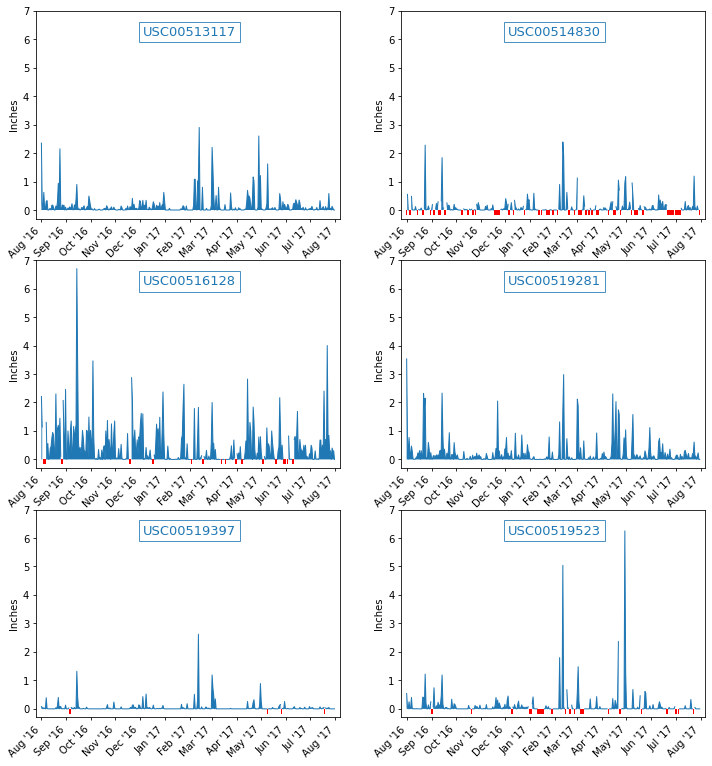

In [14]:
# Discard Coop_ID 517948 since it has limited data
df_prcp2 = df_prcp.drop(columns='USC00517948')

# Create time series for x-axis
dates = df_prcp2.index

# Prepare plot and set properties pertaining to all the figures
axs = plt.figure(figsize=(12,13)).subplots(3,2)
xmin = startdate - dt.timedelta(days=7)
xmax = enddate + dt.timedelta(days=7)
plt.setp(axs, ylim=([-0.3,7]), xlim=([xmin,xmax]), ylabel='Inches')
bbox_props = dict(boxstyle="square", fc="w", ec='tab:blue', alpha=0.8)

# Plot data, showing missing values as red bars below the x-axis
axs = axs.flat
for ax,station in zip(axs, df_prcp2.columns):
    prec = df_prcp2[station].values
    NaNs = [-0.17 if np.isnan(x) else np.nan for x in prec]
    ax.plot(dates, prec, linewidth=1)
    ax.fill_between(dates, df_prcp2[station])
    ax.bar(dates, NaNs, color='red', width=pd.Timedelta(days=1))
    ax.text(dt.datetime(2017,2,1), 6.25, station, color='tab:blue', ha="center", va="center", size=13, bbox=bbox_props)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')    
    ax.tick_params(axis='both', length=3)

plt.savefig('prec_plots.png', dpi=300)

## Additional Analyses

### Precipitation Summary Statistics

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp2.describe()

Sta_ID,USC00513117,USC00514830,USC00516128,USC00519281,USC00519397,USC00519523
count,365.000000,260.000000,331.000000,365.000000,360.000000,319.000000
mean,0.149014,0.131308,0.477069,0.217781,0.047722,0.124765
std,0.354761,0.320596,0.732042,0.462878,0.190305,0.506417
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
50%,0.030000,0.020000,0.220000,0.060000,0.000000,0.000000
75%,0.130000,0.120000,0.700000,0.200000,0.020000,0.070000
max,2.900000,2.390000,6.700000,3.530000,2.620000,6.250000


### Show Station Count

In [16]:
# Design a query to show how many stations are available in this dataset?
result = session.query(Meas.station).distinct().count()
print(f"The number of stations in the dataset is {result}.")

The number of stations in the dataset is 9.


### Most Active Stations

Note: I'm presenting separate counts for precipitation and temperature

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel = [func.count(Meas.tobs),
       func.count(Meas.prcp),
       Meas.station,
       Sta.name]

sta_obs_list = session.query(*sel).\
    filter(Meas.station == Sta.station).\
    group_by(Meas.station).\
    order_by(func.count(Meas.tobs).desc()).all()

df_obs_count = pd.DataFrame(sta_obs_list, columns=['Temp Count','Prec count','Sta_ID','Station Name'])
df_obs_count

,Temp Count,Prec count,Sta_ID,Station Name
0,2772,2772,USC00519281,"WAIHEE 837.5, HI US"
1,2724,2685,USC00519397,"WAIKIKI 717.2, HI US"
2,2709,2696,USC00513117,"KANEOHE 838.1, HI US"
3,2669,2572,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"
4,2612,2484,USC00516128,"MANOA LYON ARBO 785.2, HI US"
5,2202,1937,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
6,1979,1932,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US"
7,1372,683,USC00517948,"PEARL CITY, HI US"
8,511,342,USC00518838,"UPPER WAHIAWA 874.3, HI US"


### Temperature Statistics for Station with Highest Observation Count

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Meas.station,
       func.max(Meas.tobs),
       func.min(Meas.tobs),
       func.avg(Meas.tobs)]

temp_stats = session.query(*sel).\
    filter(Meas.station == 'USC00519281').\
    group_by(Meas.station).all()

print(f"Temperature stats for station {temp_stats[0][0]}:")
print(f"   Max  {temp_stats[0][1]}")
print(f"   Min  {temp_stats[0][2]}")
print(f"   Mean {temp_stats[0][3]:.1f}")


Temperature stats for station USC00519281:
   Max  85.0
   Min  54.0
   Mean 71.7


### Temperature Histogram for Station with Highest Observation Count (12 Bins)

365


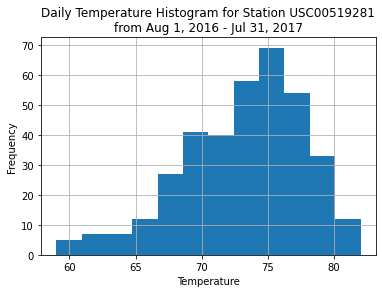

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sta_temp = session.query(Meas.date, Meas.tobs).\
    filter(Meas.station == 'USC00519281').\
    filter(Meas.date >= startdate).\
    filter(Meas.date <= enddate).\
    order_by(Meas.date).all()

df_temp = pd.DataFrame(sta_temp, columns=sta_temp[0].keys())

print(len(df_temp))

df_temp.hist(column='tobs', bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Daily Temperature Histogram for Station USC00519281\nfrom Aug 1, 2016 - Jul 31, 2017')
plt.show()

# My Own Bonus Challenge

I worked in Water Resources Environmental Science for the past 20 years, and gained considerable experience working with meteorological data. I decided to create by own "Bonus Challenge" so I could focus on 1) extending my skillset, and 2) characterizing variability and gaps in the dataset aggregated on a monthly basis. In addition, many aspects of the Bonus Challenge are likely to produce dubious results given limitations of the dataset:

1. The `calc_temps` function, as written, will find the minimum, mean, and maximum temperature across **ALL** stations. There is likely systematic variation between stations due to differences in location, elevation, position relative to mountain slopes, etc. The query should include user-specified station ID, or produce separate outputs for each station.
2. One could calculate the mean or median for each set of station statistics (e.g., the mean of all 9 minimums from the stations). However, a population of 9 stations is not likely sufficient to characterize central tendancies for larger geographic areas.
3. Plotting a bar chart and min-max error bars for a short time period (e.g., two weeks) is interesting, but the implication that temperature from the same set of days during previous year can be used to predict likely temperatures the following year is not a valid statistical inference.
4. Climate normals cannot be characterized using 6 - 8 years of data. 30 years is typically used.

In [23]:
## For Each Station Show Date Ranges, Record Counts, and Percent Missing Observations for Precipitation and Temperature

In [24]:
sel = [Meas.station, 
       func.min(Meas.date), 
       func.max(Meas.date),
       func.count(Meas.prcp),
       func.count(Meas.tobs)]
sta_summary = session.query(*sel).\
    group_by(Meas.station).\
    order_by(Meas.station).all()
cols = ['Sta_ID','Start Date','End Date', 'Prec Count', 'Temp Count']
df_obs_dates = pd.DataFrame(sta_summary, columns=cols)
df_obs_dates['Start Date'] = pd.to_datetime(df_obs_dates['Start Date'])
df_obs_dates['End Date'] = pd.to_datetime(df_obs_dates['End Date'])
df_obs_dates['Date Diff (days)'] = (df_obs_dates['End Date'] - df_obs_dates['Start Date']).dt.days + 1
df_obs_dates.set_index('Sta_ID', inplace=True)

df_prec_report = df_obs_dates[['Start Date','End Date', 'Prec Count', 'Date Diff (days)']]
df_prec_report['Percent Missing'] = [f"{x:.2%}" for x in (1 - round(df_prec_report['Prec Count'] / df_prec_report['Date Diff (days)'], 4))]
df_prec_report.drop(columns=['Date Diff (days)'], inplace=True)
display(df_prec_report)

df_temp_report = df_obs_dates[['Start Date','End Date', 'Temp Count', 'Date Diff (days)']]
df_temp_report['Percent Missing'] = [f"{x:.2%}" for x in (1 - round(df_temp_report['Temp Count'] / df_temp_report['Date Diff (days)'], 4))]
df_temp_report.drop(columns=['Date Diff (days)'], inplace=True)
display(df_temp_report)



,Start Date,End Date,Prec Count,Percent Missing
Sta_ID,,,,
USC00511918,2010-01-01,2015-10-30,1932,9.25%
USC00513117,2010-01-01,2017-07-31,2696,2.64%
USC00514830,2010-03-01,2017-08-23,1937,29.13%
USC00516128,2010-01-01,2017-08-23,2484,11.03%
USC00517948,2010-05-03,2017-07-31,683,74.20%
USC00518838,2010-01-01,2015-11-20,342,84.09%
USC00519281,2010-01-01,2017-08-18,2772,0.54%
USC00519397,2010-01-01,2017-08-23,2685,3.83%
USC00519523,2010-01-01,2017-08-23,2572,7.88%


,Start Date,End Date,Temp Count,Percent Missing
Sta_ID,,,,
USC00511918,2010-01-01,2015-10-30,1979,7.05%
USC00513117,2010-01-01,2017-07-31,2709,2.17%
USC00514830,2010-03-01,2017-08-23,2202,19.43%
USC00516128,2010-01-01,2017-08-23,2612,6.45%
USC00517948,2010-05-03,2017-07-31,1372,48.17%
USC00518838,2010-01-01,2015-11-20,511,76.23%
USC00519281,2010-01-01,2017-08-18,2772,0.54%
USC00519397,2010-01-01,2017-08-23,2724,2.44%
USC00519523,2010-01-01,2017-08-23,2669,4.41%


## Set Up Subsequent Analyses

In [25]:
# Get all data from measurement table
sel = [Meas.station, Meas.date, Meas.prcp, Meas.tobs]
df_meas = pd.DataFrame(session.query(*sel), columns=['Sta_ID','Date','Prec','Temp'])
session.close()
df_meas['Date'] = pd.to_datetime(df_meas['Date'])

# Make sure that no dates are "skipped" in the DataFrame (i.e., if none of the stations had data on a given date)
#    Number of unique dates in 'Date' column
numdates_df = df_meas['Date'].nunique()
#    Number days betwwen first and last date in 'Date' column
daterange_df = df_meas['Date'].max() - df_meas['Date'].min() + dt.timedelta(days=1)
#    Check equality
if numdates_df == daterange_df.days:
    print (f"'Dates' column contains all possible dates between first and last date")

# Create DataFrame with number of days in each month. Omit Aug 2017 since none of stations extend through the end of the month
#    Resource used for code: https://stackoverflow.com/questions/46319852/pandas-monthly-date-range-with-number-of-days
start_d = dt.date(2010, 1, 1)
end_d = dt.date(2017, 7, 30)
s = pd.Series(index=pd.date_range(start_d, end_d), dtype='object')
s_daysinmonth = s.resample('MS').size().to_period('m').rename_axis('Year_Mo')

# Add YYYY-MM Period time series for grouping
df_meas['Year_Mo'] = pd.PeriodIndex(df_meas['Date'],  freq="M")
df_meas.drop(df_meas[df_meas['Year_Mo'] == pd.Period(value='2017-08')].index, inplace = True)

'Dates' column contains all possible dates between first and last date


## Precipitation

### Show Fraction of Missing Values in Each Month

Darker colors indicate a higher fractions. If all values are missing, 'nan' is shown in black. The colorramp is applied to the entire DataFrame.

In [35]:
df_prec_count = pd.pivot_table(df_meas, values='Prec', index='Year_Mo', columns='Sta_ID', aggfunc='count')
df_prec_pcnt = df_prec_count.divide(s_daysinmonth, axis=0)
df_prec_missing = df_prec_pcnt.subtract(1, axis=0).copy()
df_prec_missing = df_prec_missing.multiply(-1, axis=0)
df_prec_missing = df_prec_missing.abs()

cm = sns.light_palette("darkred", as_cmap=True)
display(df_prec_missing.style.background_gradient(cmap=cm, axis=None))

Sta_ID,USC00511918,USC00513117,USC00514830,USC00516128,USC00517948,USC00518838,USC00519281,USC00519397,USC00519523
Year_Mo,,,,,,,,,
2010-01,0.064516,0.000000,nan,0.000000,nan,0.451613,0.000000,0.161290,0.000000
2010-02,0.107143,0.107143,nan,0.107143,nan,0.428571,0.000000,0.214286,0.000000
2010-03,0.032258,0.000000,0.161290,0.000000,nan,0.612903,0.000000,0.225806,0.000000
2010-04,0.000000,0.000000,0.066667,0.066667,nan,0.500000,0.000000,0.133333,0.000000
2010-05,0.064516,0.000000,0.161290,0.225806,0.483871,0.354839,0.000000,0.096774,0.064516
2010-06,0.033333,0.000000,0.066667,0.400000,0.333333,0.400000,0.000000,0.000000,0.033333
2010-07,0.161290,0.000000,0.161290,0.000000,0.580645,0.645161,0.000000,0.161290,0.000000
2010-08,0.000000,0.000000,0.000000,0.000000,0.322581,0.548387,0.000000,0.000000,0.000000
2010-09,0.066667,0.066667,0.000000,0.000000,0.366667,0.433333,0.000000,0.033333,0.000000


### Show Sum of Precipitation For Each Month

1. Four stations with significant gaps are dropped.
2. Sums are adjusted upwards to account for missing days (if present) using `Adj Prec = Prec / (1 - FractionMissing)`. For example, if the sum is 6.0 inches and 25% of the observations are missing, the adjusted value is 6.0 / (1 - 0.25), or 8.0 inches. Note that this is more of a back-of-the-envelop method and is not recommended as a rigorous adjustment procedure.
3. The colorramp is applied to each column individually (i.e., the highest value within each column is colored dark blue and the color scales are individualized according to the column's min-max range).

In [36]:
df_prec_sum = pd.pivot_table(df_meas, values='Prec', index='Year_Mo', columns='Sta_ID', aggfunc='sum')
df_prec_sum = df_prec_sum.divide(df_prec_pcnt, axis=0)

sta_keep = ['USC00513117','USC00516128','USC00519281','USC00519397','USC00519523']
df_prec_sum = df_prec_sum[sta_keep]
display(df_prec_sum.style.background_gradient(cmap='YlGnBu'))

Sta_ID,USC00513117,USC00516128,USC00519281,USC00519397,USC00519523
Year_Mo,,,,,
2010-01,3.250000,3.220000,4.820000,0.417308,5.940000
2010-02,1.713600,3.774400,1.500000,0.101818,1.480000
2010-03,2.590000,13.790000,4.570000,1.020417,2.010000
2010-04,1.910000,16.082143,6.240000,0.830769,1.350000
2010-05,1.770000,7.052500,4.520000,0.520357,1.207931
2010-06,0.860000,7.333333,1.590000,0.030000,0.351724
2010-07,2.380000,15.640000,3.970000,0.810769,1.290000
2010-08,2.240000,13.420000,3.230000,0.430000,1.380000
2010-09,1.692857,8.880000,3.220000,0.817241,2.070000


### Generate Plots

1. Time series.
2. Boxplots showing variation by station across all months in the dataset. Means shown with triangles
3. Boxplots showing variation by month across all months and stations in the dataset. Means shown with triangles

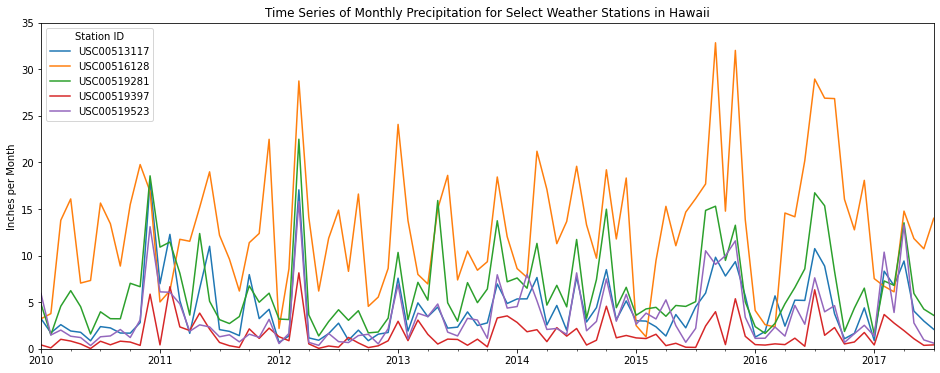

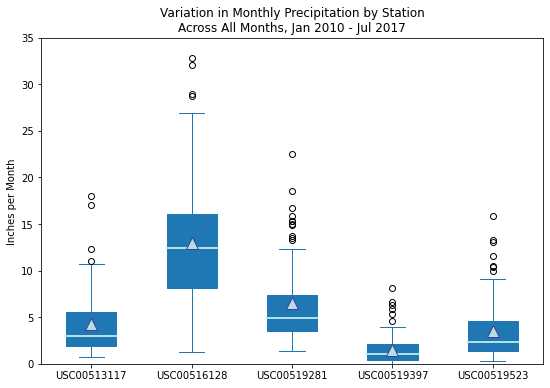

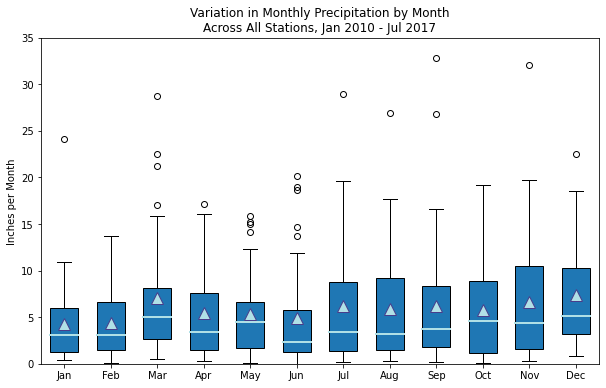

In [47]:
# Plot of monthly precipitation time series
ax = df_prec_sum.plot(figsize=(16,6), ylim=(0,35), xlabel='', ylabel='Inches per Month',
                 title='Time Series of Monthly Precipitation for Select Weather Stations in Hawaii')
ax.legend(title='Station ID')
plt.show();

# First boxplot
medianprops = {'linewidth':2, 'color':'PowderBlue'}
meanprops = {'markersize':12, 'markerfacecolor':'PowderBlue', 'markeredgecolor':'DarkSlateBlue'}
df_prec_sum.plot.box(medianprops=medianprops, showmeans=True, meanprops=meanprops, figsize=(9,6), 
                     patch_artist=True, ylabel='Inches per Month', ylim=(0,35), 
                     title='Variation in Monthly Precipitation by Station\nAcross All Months, Jan 2010 - Jul 2017');
plt.show();

# Second boxplot
df_prec_sum_stack = df_prec_sum.stack()
gb_prec_mo = df_prec_sum_stack.groupby(lambda x: x.strftime("%b"), level='Year_Mo', sort=False)
labels = []
groups = []
for name, grp in gb_prec_mo:
    labels.append(name)
    groups.append(grp.values)
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(groups, patch_artist=True, labels=labels, showmeans=True, medianprops=medianprops, 
           meanprops=meanprops, widths=0.6)
ax.set_ylim(0,35)
ax.set_ylabel('Inches per Month')
ax.set_title('Variation in Monthly Precipitation by Month\nAcross All Stations, Jan 2010 - Jul 2017')
plt.show();

## Temperature

### Show Fraction of Missing Values in Each Month

Darker colors indicate a higher fractions. If all values are missing, 'nan' is shown in black. The colorramp is applied to the entire DataFrame.

In [48]:
df_temp_count = pd.pivot_table(df_meas, values='Temp', index='Year_Mo', columns='Sta_ID', aggfunc='count')
df_temp_pcnt = df_temp_count.divide(s_daysinmonth, axis=0)
df_temp_missing = df_temp_pcnt.subtract(1, axis=0).copy()
df_temp_missing = df_temp_missing.multiply(-1, axis=0)
df_temp_missing = df_temp_missing.abs()

cm = sns.light_palette("darkred", as_cmap=True)
display(df_temp_missing.style.background_gradient(cmap=cm, axis=None))

Sta_ID,USC00511918,USC00513117,USC00514830,USC00516128,USC00517948,USC00518838,USC00519281,USC00519397,USC00519523
Year_Mo,,,,,,,,,
2010-01,0.064516,0.000000,nan,0.000000,nan,0.354839,0.000000,0.096774,0.000000
2010-02,0.071429,0.071429,nan,0.071429,nan,0.285714,0.000000,0.142857,0.000000
2010-03,0.032258,0.000000,0.096774,0.000000,nan,0.387097,0.000000,0.161290,0.000000
2010-04,0.000000,0.000000,0.033333,0.033333,nan,0.266667,0.000000,0.133333,0.000000
2010-05,0.032258,0.000000,0.096774,0.129032,0.387097,0.290323,0.000000,0.064516,0.064516
2010-06,0.033333,0.000000,0.033333,0.266667,0.333333,0.233333,0.000000,0.000000,0.033333
2010-07,0.096774,0.000000,0.129032,0.000000,0.548387,0.516129,0.000000,0.129032,0.000000
2010-08,0.000000,0.000000,0.000000,0.000000,0.322581,0.322581,0.000000,0.000000,0.000000
2010-09,0.066667,0.033333,0.000000,0.000000,0.366667,0.233333,0.000000,0.033333,0.000000


### Show Mean Temperature For Each Month

1. Four stations with significant gaps are dropped.
2. No adjustment is made to the means to account for fraction of missing observations. Months with missing values have a higher degree of uncertainty and unknown bias.
3. The colorramp is applied to each column individually (i.e., the highest value within each column is colored dark blue and the color scales are individualized according to the column's min-max range).

In [49]:
df_temp_mean = pd.pivot_table(df_meas, values='Temp', index='Year_Mo', columns='Sta_ID', aggfunc='mean')

sta_keep = ['USC00513117','USC00516128','USC00519281','USC00519397','USC00519523']
df_temp_mean = df_temp_mean[sta_keep]
display(df_temp_mean.style.background_gradient(cmap='RdYlGn_r'))

Sta_ID,USC00513117,USC00516128,USC00519281,USC00519397,USC00519523
Year_Mo,,,,,
2010-01,70.225806,69.419355,68.612903,68.285714,69.967742
2010-02,68.076923,68.384615,66.464286,68.000000,68.035714
2010-03,70.064516,69.161290,69.354839,71.384615,71.612903
2010-04,71.066667,70.724138,70.100000,73.576923,72.200000
2010-05,73.387097,72.629630,72.419355,76.344828,75.551724
2010-06,74.800000,72.863636,73.633333,77.766667,76.172414
2010-07,74.290323,70.580645,72.580645,77.407407,75.935484
2010-08,74.451613,71.000000,74.967742,77.612903,76.387097
2010-09,74.931034,71.833333,73.266667,77.103448,76.033333


### Generate Plots

1. Time series.
2. Boxplots showing variation by station across all months in the dataset. Means shown with triangles
3. Boxplots showing variation by month across all months and stations in the dataset. Means shown with triangles

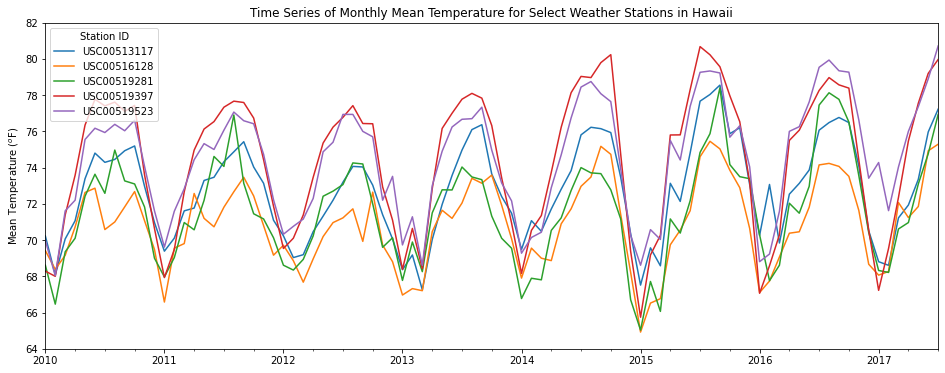

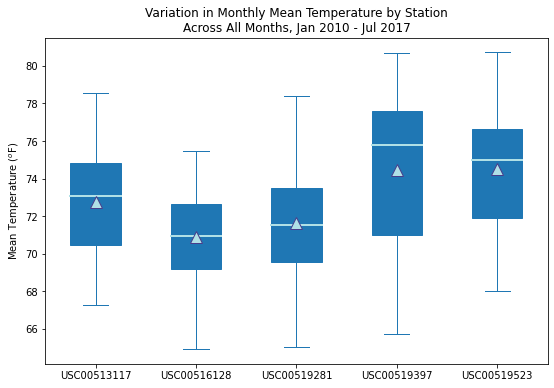

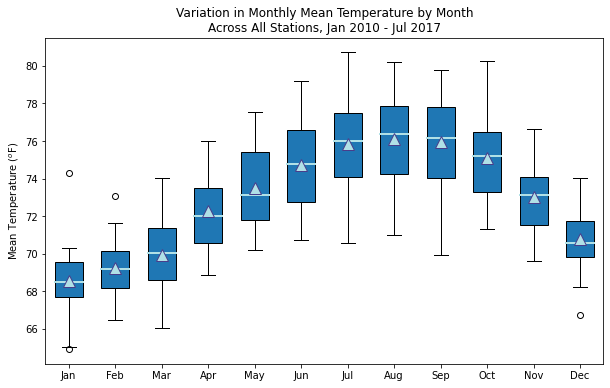

In [50]:
# Plot of monthly temperature time series
ax = df_temp_mean.plot(figsize=(16,6), ylim=(64,82), xlabel='', ylabel='Mean Temperature ($^o$F)',
                 title='Time Series of Monthly Mean Temperature for Select Weather Stations in Hawaii')
ax.legend(title='Station ID')
plt.show();

# First boxplot
medianprops = {'linewidth':2, 'color':'PowderBlue'}
meanprops = {'markersize':12, 'markerfacecolor':'PowderBlue', 'markeredgecolor':'DarkSlateBlue'}
df_temp_mean.plot.box(medianprops=medianprops, showmeans=True, meanprops=meanprops, figsize=(9,6), 
                     patch_artist=True, ylabel='Mean Temperature ($^o$F)', 
                     title='Variation in Monthly Mean Temperature by Station\nAcross All Months, Jan 2010 - Jul 2017');
plt.show();

# Second boxplot
df_temp_mean_stack = df_temp_mean.stack()
gb_temp_mo = df_temp_mean_stack.groupby(lambda x: x.strftime("%b"), level='Year_Mo', sort=False)
labels = []
groups = []
for name, grp in gb_temp_mo:
    labels.append(name)
    groups.append(grp.values)
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(groups, patch_artist=True, labels=labels, showmeans=True, medianprops=medianprops, 
           meanprops=meanprops, widths=0.6)
ax.set_ylabel('Mean Temperature ($^o$F)')
ax.set_title('Variation in Monthly Mean Temperature by Month\nAcross All Stations, Jan 2010 - Jul 2017')
plt.show();

#### Keeping this as a handy reference for named color ramps

ValueError: 'RBu' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'